Load a map from an image file and process it for the game.
Upload an image file (e.g., map.png).


Saving Capture.PNG to Capture (24).PNG
File uploaded: Capture (24).PNG
Enter the number of rows for the grid (e.g., 400): 100
Enter the number of columns for the grid (e.g., 400): 100


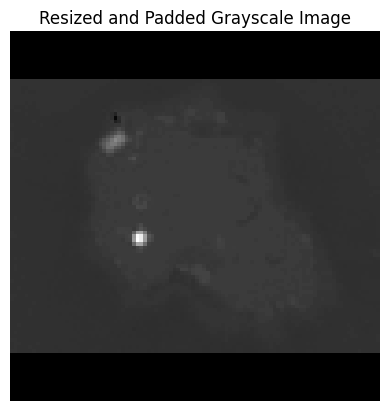

Calculated Threshold: 35.0


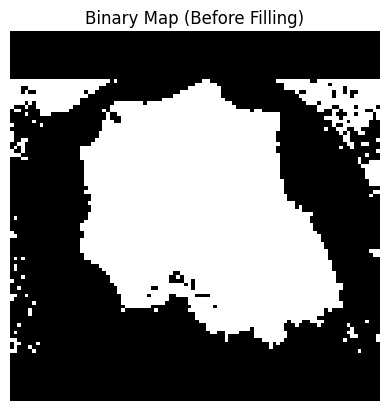

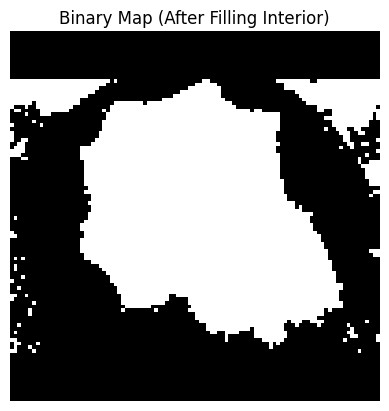

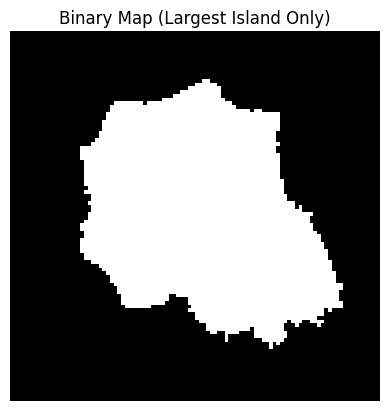

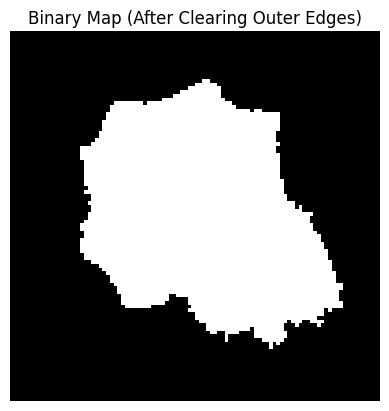

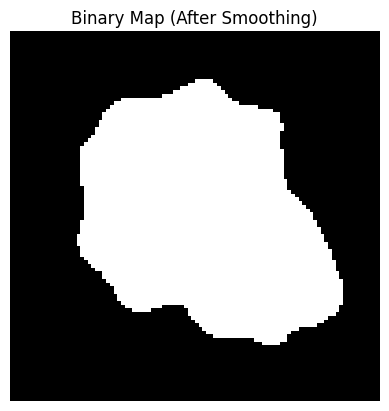

Displaying the high-resolution smoothed and finalized island map...


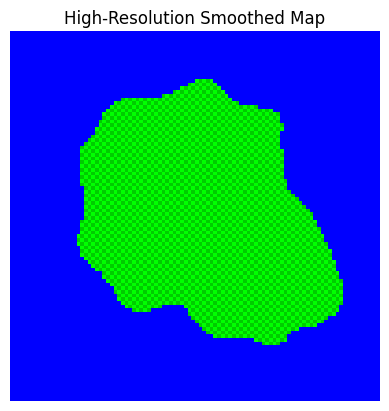

In [36]:
"""
@author - Eric Huynh
@updated - 23 January 2025
@file - PIG.ipynb
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, binary_dilation, binary_fill_holes, label
from PIL import Image, ImageOps
from google.colab import files  # For uploading files in Google Colab

def upload_image():
    # Ask the user to upload an image file (like map.png)
    print("Upload an image file (e.g., map.png).")
    uploaded = files.upload()
    if uploaded:
        file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file
        print(f"File uploaded: {file_name}")
        return file_name
    else:
        raise FileNotFoundError("No file was uploaded. Please try again.")

def resize_and_pad_image(img, rows, cols):
    """
    Resize the image to fit the grid dimensions while keeping its proportions.
    If it doesn't fit exactly, add black padding to make it the correct size.
    """
    img.thumbnail((cols, rows), Image.Resampling.LANCZOS)  # Resize the image
    delta_w = cols - img.size[0]  # How much padding is needed for width
    delta_h = rows - img.size[1]  # How much padding is needed for height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    padded_img = ImageOps.expand(img, padding, fill=0)  # Add black padding (represents water)

    # Debugging statement for checking the padded image dimensions
    # print(f"Padded Image Shape: {np.array(padded_img).shape}")

    return np.array(padded_img)

def histogram_threshold(img_array, percentage=0.5):
    """
    Use the histogram to figure out a threshold value for separating land and water.
    `percentage` decides how much of the image is land.
    """
    hist, bins = np.histogram(img_array.flatten(), bins=256, range=(0, 256))
    cumulative = np.cumsum(hist)  # Get cumulative histogram values
    total_pixels = img_array.size
    threshold_index = np.searchsorted(cumulative, total_pixels * percentage)  # Find the cutoff

    # Debugging statement for checking the histogram and threshold
    # print(f"Histogram: {hist}")
    # print(f"Cumulative Histogram: {cumulative}")
    # print(f"Threshold Index: {threshold_index}, Threshold Value: {bins[threshold_index]}")

    return bins[threshold_index]

def preprocess_image(file_path, rows, cols, percentage=0.4):
    # Open the image and turn it into grayscale (black and white, basically)
    img = Image.open(file_path).convert("L")

    # Resize and pad the image to match the grid size
    img_array = resize_and_pad_image(img, rows, cols)

    # Show the resized and padded grayscale image
    plt.imshow(img_array, cmap='gray')
    plt.title("Resized and Padded Grayscale Image")
    plt.axis('off')
    plt.show()

    # Use the histogram to calculate a threshold for land vs. water
    threshold = histogram_threshold(img_array, percentage=percentage)
    print(f"Calculated Threshold: {threshold}")

    # Turn the image into a binary map: 1 for land, 0 for water
    binary_map = (img_array > threshold).astype(int)

    # Debugging statement for checking binary conversion
    # print(f"Binary Map (Shape): {binary_map.shape}, Unique Values: {np.unique(binary_map)}")

    # Show the binary map (just for debugging)
    plt.imshow(binary_map, cmap='gray')
    plt.title("Binary Map (Before Filling)")
    plt.axis('off')
    plt.show()

    return binary_map

def fill_interior(binary_map):
    # Fill in any gaps in the land to make sure the interior is solid
    filled_map = binary_fill_holes(binary_map).astype(int)

    # Debugging statement for checking filled interior
    # print(f"Filled Map Unique Values: {np.unique(filled_map)}")

    # Show the filled binary map (debugging)
    plt.imshow(filled_map, cmap='gray')
    plt.title("Binary Map (After Filling Interior)")
    plt.axis('off')
    plt.show()

    return filled_map

def retain_largest_island(binary_map):
    """
    Keep only the biggest landmass and throw away smaller ones (like stray pixels).
    """
    labeled_map, num_features = label(binary_map)
    if num_features == 0:
        return binary_map  # No land detected, return the map as is

    # Debugging statement for labeled components
    # print(f"Number of Features Detected: {num_features}")

    # Find the biggest connected landmass
    largest_component = (labeled_map == np.argmax(np.bincount(labeled_map.flat)[1:]) + 1).astype(int)

    # Show the largest island for debugging
    plt.imshow(largest_component, cmap='gray')
    plt.title("Binary Map (Largest Island Only)")
    plt.axis('off')
    plt.show()

    return largest_component

def clear_outer_edges(binary_map):
    """
    Make sure the outer edges of the map are all water (to keep the land surrounded).
    """
    cleared_map = binary_map.copy()
    cleared_map[0, :] = 0  # Clear the top edge
    cleared_map[-1, :] = 0  # Clear the bottom edge
    cleared_map[:, 0] = 0  # Clear the left edge
    cleared_map[:, -1] = 0  # Clear the right edge

    # Debugging statement for cleared edges
    # print(f"Cleared Map Edge Values: Top: {cleared_map[0, :]}, Bottom: {cleared_map[-1, :]}")

    # Show the map after clearing the edges
    plt.imshow(cleared_map, cmap='gray')
    plt.title("Binary Map (After Clearing Outer Edges)")
    plt.axis('off')
    plt.show()

    return cleared_map

def dilate_and_smooth(binary_map, sigma=2.5, dilation_iterations=1):
    """
    Expand the land a bit (dilation) and then smooth out any sharp edges.
    """
    # Expand the land
    dilated_map = binary_dilation(binary_map, iterations=dilation_iterations).astype(int)

    # Debugging statement for dilation
    # print(f"Dilated Map Shape: {dilated_map.shape}, Unique Values: {np.unique(dilated_map)}")

    # Smooth the edges
    smoothed = gaussian_filter(dilated_map.astype(float), sigma=sigma)

    # Re-binarize the smoothed map
    smoothed_map = (smoothed > 0.5).astype(int)

    # Show the smoothed map
    plt.imshow(smoothed_map, cmap='gray')
    plt.title("Binary Map (After Smoothing)")
    plt.axis('off')
    plt.show()

    return smoothed_map

def display_high_res_map(grid, upscale_factor=2):
    """
    Show the final map in high resolution with a checkerboard pattern for the land.
    """
    rows, cols = grid.shape
    high_res = np.zeros((rows * upscale_factor, cols * upscale_factor, 3))  # RGB map

    for i in range(rows):
        for j in range(cols):
            if grid[i, j] == 0:  # Water (blue)
                high_res[i * upscale_factor:(i + 1) * upscale_factor,
                         j * upscale_factor:(j + 1) * upscale_factor] = [0, 0, 1]
            elif grid[i, j] == 1:  # Land (alternating green)
                color = [0, 0.8, 0] if (i + j) % 2 == 0 else [0, 1, 0]
                high_res[i * upscale_factor:(i + 1) * upscale_factor,
                         j * upscale_factor:(j + 1) * upscale_factor] = color

    # Debugging statement for checking the high-resolution map shape
    # print(f"High-Res Map Shape: {high_res.shape}")

    plt.imshow(high_res, interpolation='nearest')
    plt.axis('off')
    plt.title("High-Resolution Smoothed Map")
    plt.show()

# Main script
def main():
    print("Load a map from an image file and process it for the game.")
    try:
        # Allow the user to upload a file
        file_path = upload_image()

        # Get grid dimensions from the user
        rows = int(input("Enter the number of rows for the grid (e.g., 400): "))
        cols = int(input("Enter the number of columns for the grid (e.g., 400): "))

        if rows < 3 or cols < 3:
            print("Dimensions must be at least 3x3 for a meaningful map.")
            return

        # Preprocess the image (resize, threshold)
        binary_map = preprocess_image(file_path, rows, cols, percentage=0.4)  # Adjust percentage if needed

        # Fill any interior gaps in the landmass
        filled_map = fill_interior(binary_map)

        # Retain only the largest island
        largest_island = retain_largest_island(filled_map)

        # Clear outer edges to ensure the landmass is an island
        cleared_map = clear_outer_edges(largest_island)

        # Dilate and smooth the edges
        smoothed_map = dilate_and_smooth(cleared_map, sigma=2.5, dilation_iterations=1)

        # Display the high-resolution final map
        print("Displaying the high-resolution smoothed and finalized island map...")
        display_high_res_map(smoothed_map, upscale_factor=4)  # Increase upscale_factor as needed

    except FileNotFoundError as e:
        print(str(e))
    except ValueError:
        print("Please enter valid integers for rows and columns.")

if __name__ == "__main__":
    main()
